# Column-shift of superpositions

In [1]:
import math
import matplotlib.pyplot as plt

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute, BasicAer
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import MCMT, RYGate, RZGate, XGate, MCXGate, SwapGate

### Increment by one circuit

In [2]:
'''
Returns a quantum circuit that increments a value by one (i.e., 001 -> 010)
    - value_register_size : the size of the register encoding a given value
'''

def inc_by_one(value_register_size: int, name='inc_by_one') -> QuantumCircuit:
    value_register = QuantumRegister(value_register_size, 'value_register')
    one = QuantumRegister(1, 'one')
    qc = QuantumCircuit(value_register, one, name=name)

    for i in range(len(value_register)-1):
        qc.cx(one, value_register[i]) 
        for p in reversed(range(i)):
            qc.x(value_register[p])
        qc.append(MCXGate(num_ctrl_qubits=len(value_register[:i])+1), value_register[:i+1]+one[0:])
        for p in reversed(range(i)):
            qc.x(value_register[p])

    qc.cx(one, value_register[-1])
    qc.x(one)

    for p in range(len(value_register)-1):
        qc.x(value_register[p])
    qc.append(MCXGate(num_ctrl_qubits=len(value_register)-1), value_register[:-1]+one[0:])
    for p in range(len(value_register)-1):
        qc.x(value_register[p])
    
    return qc.to_gate()

### Switch Address

In [3]:
'''
Returns a quantum circuit that targets a specific superposition.
    - address_value: the address to access.
    - addr_register_size: the register size encoding address_value
'''

def address_switcher(address: int, addr_register_size: int) -> QuantumCircuit:    
    address_register = QuantumRegister(addr_register_size, 'address_index')
    address_circuit = QuantumCircuit(address_register, name='address:'+str(address))
    
    bin_str_pattern = '{:0%sb}' % len(address_register)
    address_string = bin_str_pattern.format(address)[::-1]
    for idx, bit in enumerate(address_string):
        if not int(bit):
            address_circuit.x(address_register[idx])
    return address_circuit

## Encode a value

In [4]:
'''
Returns a quantum circuit that encodes a value in a specific superposition of addresses.
    - address_value: the address to access.
    - addr_size: the register size encoding address_value
'''

def encode_value(address: int, addr_register_size: int, value: str, value_register_size: int) -> QuantumCircuit:
    address_register = QuantumRegister(addr_register_size, 'address_index')
    value_register = QuantumRegister(value_register_size, 'value_register')
    value_qc = QuantumCircuit(address_register, value_register, name=value)
    
    value_qc.append(address_switcher(address, len(address_register)), address_register[0:])
    for pos, bit in zip(range(len(value)), value[::-1]):
        if int(bit):
            value_qc.append(MCXGate(num_ctrl_qubits=len(address_register)), address_register[0:]+[value_register[pos]] )
    value_qc.append(address_switcher(address, len(address_register)), address_register[0:])
    return value_qc


## Encode a dataset according binary encoding

In [5]:
'''
Returns a quantum circuit that encodes a dataset of binary values.
    - dataset: the dataset of binary values
'''

def get_dataset_circuit(dataset: list[str]) -> QuantumCircuit:
    address_register = QuantumRegister(int(math.ceil(math.log(len(dataset)))), 'addr_index')
    value_register = QuantumRegister(len(dataset[0]), 'data')
    qc_dataset = QuantumCircuit(address_register, value_register, name='dataset')
    
    qc_dataset.barrier()
    for address, value in zip(range(len(dataset)), dataset):
        qc_dataset.append(encode_value(address, len(address_register), value, len(value_register)), address_register[0:]+value_register[0:])
        qc_dataset.barrier()

    return qc_dataset 

## Main

In [6]:
## Set Parameters
dataset = ['111', '100', '000', '110']

# set the column to circular-shift
column_to_shift = 1

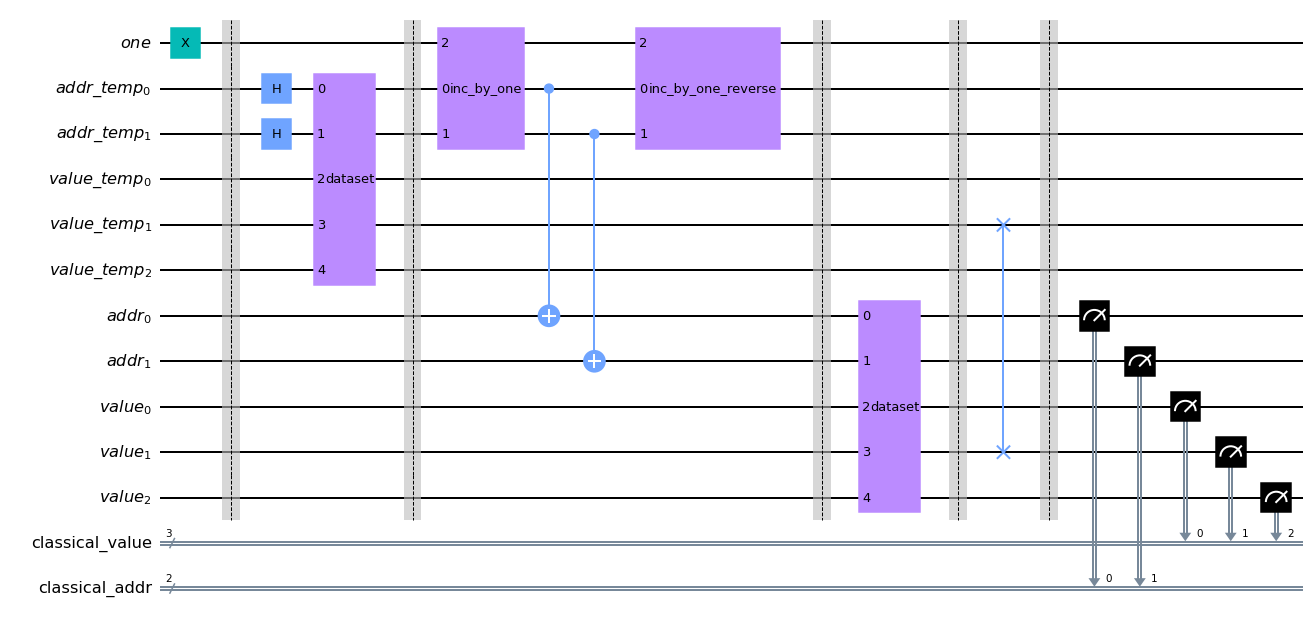

In [7]:
addr_register_temp = QuantumRegister(int(math.ceil(math.log(len(dataset)))), 'addr_temp')
value_register_temp = QuantumRegister(len(dataset[0]), 'value_temp')

addr_register = QuantumRegister(int(math.ceil(math.log(len(dataset)))), 'addr')
value_register = QuantumRegister(len(dataset[0]), 'value')

classical_addr = ClassicalRegister(len(addr_register), 'classical_addr')
classical_value = ClassicalRegister(len(value_register), 'classical_value')

one = QuantumRegister(1, 'one')

qc = QuantumCircuit(one,
                    addr_register_temp,
                    value_register_temp,
                    addr_register,
                    value_register,
                    classical_value,
                    classical_addr)


qc.x(one) # set to 1 variable 'one'

qc.barrier()

qc.h(addr_register_temp) # create superposition of addresses

qc.append(get_dataset_circuit(dataset), addr_register_temp[0:]+value_register_temp[0:]) # append dataset circuit

qc.barrier()

qc.append(inc_by_one(len(addr_register_temp)), addr_register_temp[0:]+[one[0]]) # increment_by_one
for pos in range(len(addr_register_temp)): # copy superposition of incremented addresses to address_register_2
    qc.cx(addr_register_temp[pos],addr_register[pos])
qc.append(inc_by_one(len(addr_register_temp)).reverse_ops(), addr_register_temp[0:]+[one[0]]) # undo-increment_by_one

qc.barrier()

qc.append(get_dataset_circuit(dataset), addr_register[0:]+value_register[0:]) # append dataset circuit

qc.barrier()

qc.swap(value_register_temp[column_to_shift], value_register[column_to_shift])  # column-shift

qc.barrier()

qc.measure(addr_register, classical_addr)
qc.measure(value_register, classical_value)

qc.draw('mpl')

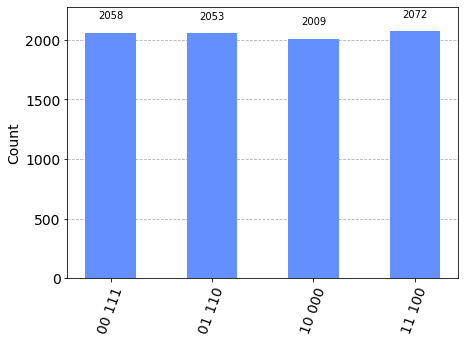

In [8]:
#INPUT: dataset = [00:'111', 01:'100', 10:'000', 11:110']
#EXPECTED_OUTPUT: dataset_column_middle_shift = [00:'111', 01:'110', 10:'000', 11:'100']

simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, simulator, shots=8192).result()
counts = result.get_counts(qc)

plot_histogram(counts)